<img src = 'image/k-water_logo.png' alt = 'Drawing' style = 'width: 200px;'/>

<p style='font-size:30px; line-height:1em'>[Notebook] 알고리즘별 누수 판별(유사 Mass Balance) </p>

# 분석개요

## 분석과정
분석환경 설정 > 데이터 가져오기 > 유사 Mass Balnce 그래프

## 데이터 설명
* 데이터 유형: csv
* 파일 크기: 관측치 1803개(행), 변수 5개(열)
* 데이터 수집: 'Notebook_R_데이터 기반 상수관망 사고사례 분석 및 이상감지' output 파일
* 데이터 내용: 2016년 충남중부권 상수도 사고 데이터에 대한 구간별 유량 예측값 

## 변수 설명
총 변수 수: 5개  
* 시간 변수: DATE
* 그 외 변수: ACTUAL(실제 유량값), LM(선형회귀모형을 활용한 예측값), SVM_LINEAR(선형 서포트 벡터 머신을 활용한 예측값), SVM_RBF(비선형 서포트 벡터 머신을 활용한 예측값)

# 분석환경 설정

In [ ]:
# 작업 디렉토리 설정
setwd(paste0('/home/', Sys.getenv('USER') ,'/recipe01'))

# 작업 디렉토리 확인
getwd()

## 패키지 불러오기

* dplyr: arrange(), mutate(), 파이프 연산자(%>%)
* lubridate: ymd(), hours()
* ggplot2: ggplot()
* scales : date_format()

In [2]:
# 패키지 불러오기
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(lubridate)
    library(scales)
})

# 데이터 가져오기

In [3]:
# 데이터 가져오기(csv 파일)
sector1 <- read.csv('output/result of test in sector1.csv')
sector2 <- read.csv('output/result of test in sector2.csv')
sector3 <- read.csv('output/result of test in sector3.csv')

In [4]:
# 데이터 가공하기
# 구분을 위한 group 변수 생성
sector1 <- sector1 %>% mutate(GROUP = 'sector1')
sector2 <- sector2 %>% mutate(GROUP = 'sector2')
sector3 <- sector3 %>% mutate(GROUP = 'sector3')

# 데이터 병합(행 결합)
total_df <- rbind(sector1, sector2, sector3)

# 변수형 변환 및 정렬
total_df$DATE <- lubridate::ymd_hms(total_df$DATE) # 변수형 변환(문자형 > 날짜시간형)
tatal_df <- arrange(total_df, DATE) # DATE 기준 오름차순 정렬

구간별 예측 결과가 저장된 csv 파일을 불러옵니다. 이 csv 파일은 'Notebook_R_데이터 기반 상수관망 사고사례 분석 및 이상감지'를 실행하여 얻을 수 있습니다.

구분을 위해 구간을 알 수 있도록 group 변수를 생성한 후, 데이터를 병합합니다. 변수 DATE가 문자형이므로 ymd_hms() 함수를 이용해서 날짜시간형으로 변환합니다. 마지막으로 변수 DATE를 기준으로 오름차순 정렬을 합니다.

In [5]:
# 데이터 확인하기

# 가공된 데이터 구조 확인
str(total_df)

head(total_df, n = 10)

'data.frame':	1803 obs. of  6 variables:
 $ DATE      : POSIXct, format: "2016-10-11 00:00:00" "2016-10-11 00:01:00" ...
 $ ACTUAL    : int  4003 4006 4025 4031 4000 4006 4014 4008 3994 4011 ...
 $ LM        : num  4606 4849 4456 4830 4520 ...
 $ SVM_LINEAR: num  4647 4903 4489 4884 4556 ...
 $ SVM_RBF   : num  4577 3973 4462 4031 4515 ...
 $ GROUP     : chr  "sector1" "sector1" "sector1" "sector1" ...


,DATE,ACTUAL,LM,SVM_LINEAR,SVM_RBF,GROUP
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,2016-10-11 00:00:00,4003,4606.148,4647.296,4577.310,sector1
2,2016-10-11 00:01:00,4006,4848.626,4903.304,3973.343,sector1
3,2016-10-11 00:02:00,4025,4455.811,4488.571,4462.294,sector1
4,2016-10-11 00:03:00,4031,4829.974,4883.611,4030.872,sector1
5,2016-10-11 00:04:00,4000,4519.881,4556.216,4515.340,sector1
6,2016-10-11 00:05:00,4006,4498.897,4534.062,4496.244,sector1
7,2016-10-11 00:06:00,4014,4469.800,4503.341,4472.813,sector1
8,2016-10-11 00:07:00,4008,4399.854,4429.493,4414.820,sector1
9,2016-10-11 00:08:00,3994,4338.022,4364.211,4361.176,sector1


변수 Date가 POSIXct 클래스로 바뀐 것을 확인 할 수 있습니다.  
(참고) POSIXct 클래스는 시간을 초 단위의 정수로 기록하는 클래스입니다.

# 유사 Mass Balance 그래프

기본 Mass Balane은 각 지점별 유량계가 모두 완비된 경우, 단순 뺄셈(공급유량-수수유량)에 의해 누수 구간 식별이 가능합니다.  하지만 유량계는 고가이고, 설치를 위해 요구되는 최소 직관 거리가 있기 때문에 미설치된 지점이 많습니다.  

그래서 저가이고 설치를 위한 직관 거리가 필요하지 않은 유압계를 활용해 누수 구간을 식별하고자 합니다. 'Notebook_R_광역_상수관망_누수_감지'에서 지점 간 유압 차(차압) 데이터를 활용하여 유량을 예측했습니다. 예측한 결과를 활용하여 유사 Mass Balance를 계산하고 이를 시각화하여 누수 발생 구간을 식별합니다.

## 선형회귀

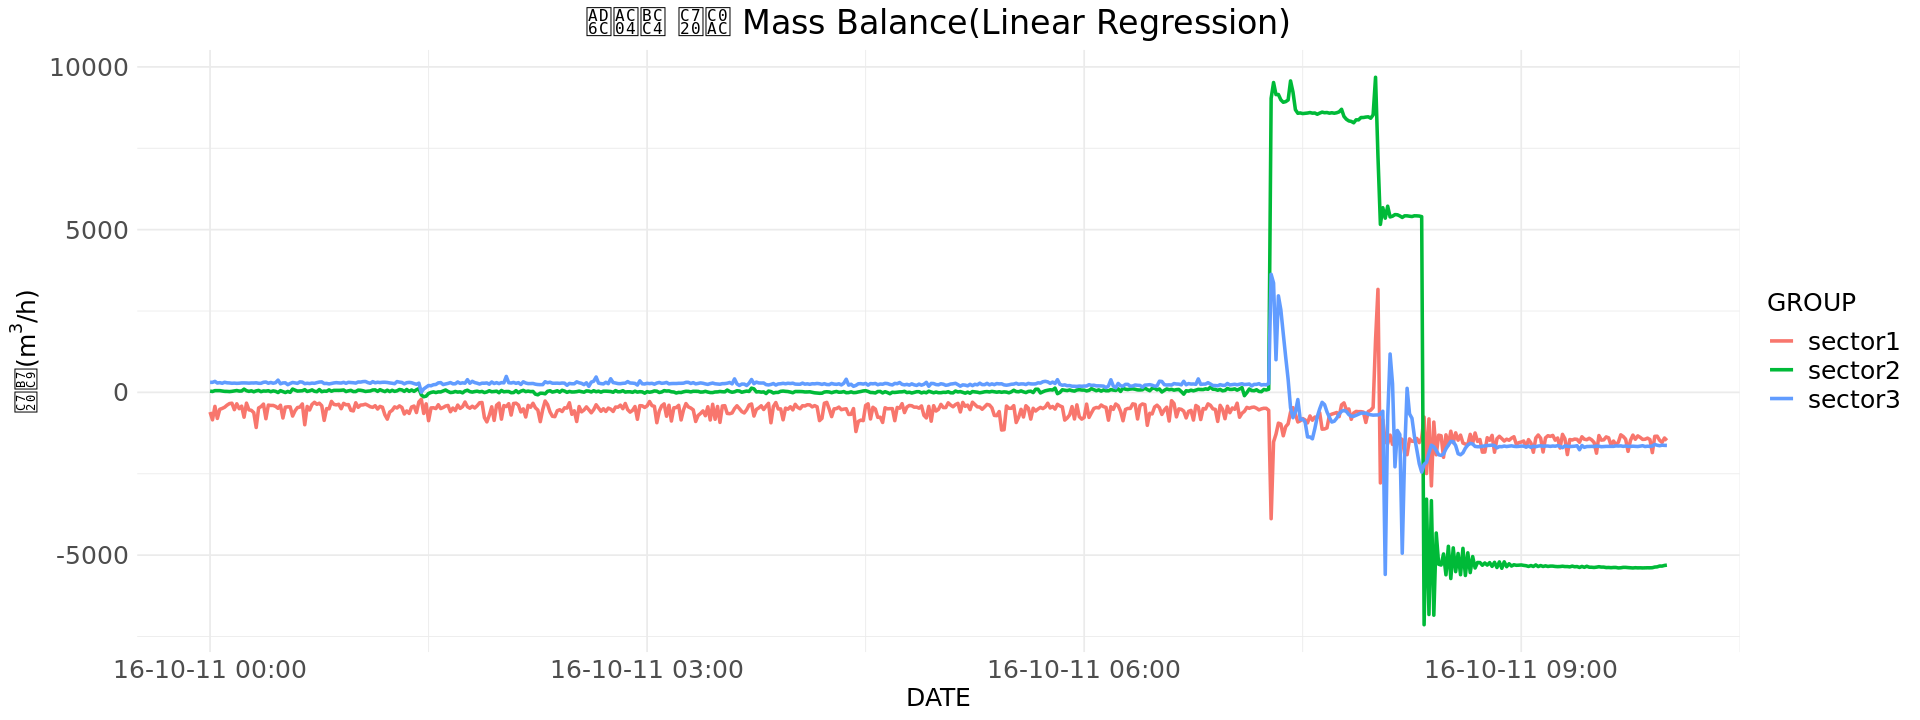

In [6]:
# Linear Regression
options(repr.plot.width = 16, repr.plot.height = 6)
ggplot(total_df, aes(x = DATE, y = (ACTUAL-LM), group = GROUP)) + 
    geom_line(aes(color = GROUP), linewidth = 1) + ylab(expression(paste('유량(', m^{3}, '/h)'))) + 
    ggtitle('구간별 유사 Mass Balance(Linear Regression)') +
    theme_minimal() + theme(plot.title = element_text(hjust = 0.5, size = 20), 
                            strip.text.x = element_text(size = 15), axis.title = element_text(size = 15), 
                            axis.text = element_text(size = 15), legend.text = element_text(size = 15), 
                            legend.title = element_text(size = 15)) + 
    scale_x_datetime(labels = date_format('%y-%m-%d %H:%M'))

선형회귀를 활용한 구간별 유사 Mass Balance입니다.   
누수가 발생한 2구간에서만 증가하는 모습을 확인할 수 있습니다. 따라서 선형회귀를 통해 누수 구간을 식별할 수 있습니다.

## 선형 서포트 벡터 머신

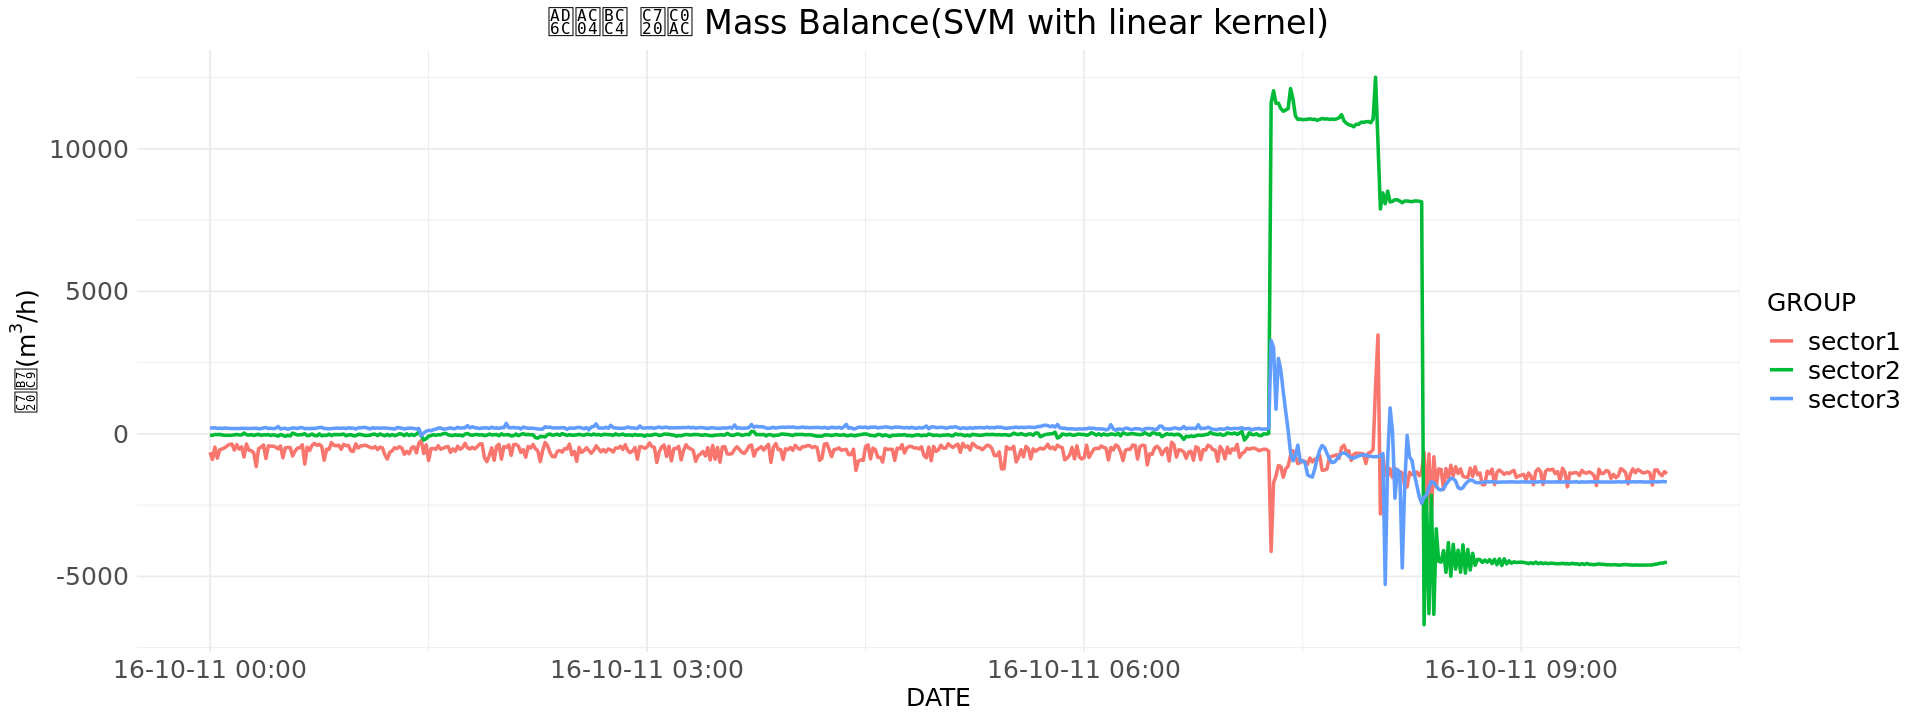

In [7]:
# Support Vector Machine(with linear kernel)
ggplot(total_df, aes(x = DATE, y = (ACTUAL-SVM_LINEAR), group = GROUP)) + 
    geom_line(aes(color = GROUP), linewidth = 1) + ylab(expression(paste('유량(', m^{3}, '/h)'))) + 
    ggtitle('구간별 유사 Mass Balance(SVM with linear kernel)') +
    theme_minimal() + theme(plot.title = element_text(hjust = 0.5, size = 20), 
                            strip.text.x = element_text(size = 15), axis.title = element_text(size = 15), 
                            axis.text = element_text(size = 15), legend.text = element_text(size = 15), 
                            legend.title = element_text(size = 15)) + 
    scale_x_datetime(labels = date_format('%y-%m-%d %H:%M'))

선형 서포트 벡터 머신을 활용한 구간별 유사 Mass Balance입니다.   
누수가 발생한 2구간에서만 증가하는 모습을 확인할 수 있습니다. 따라서 선형 서포트 벡터 머신을 통해 누수 구간을 식별할 수 있습니다.

## 비선형 서포트 벡터 머신

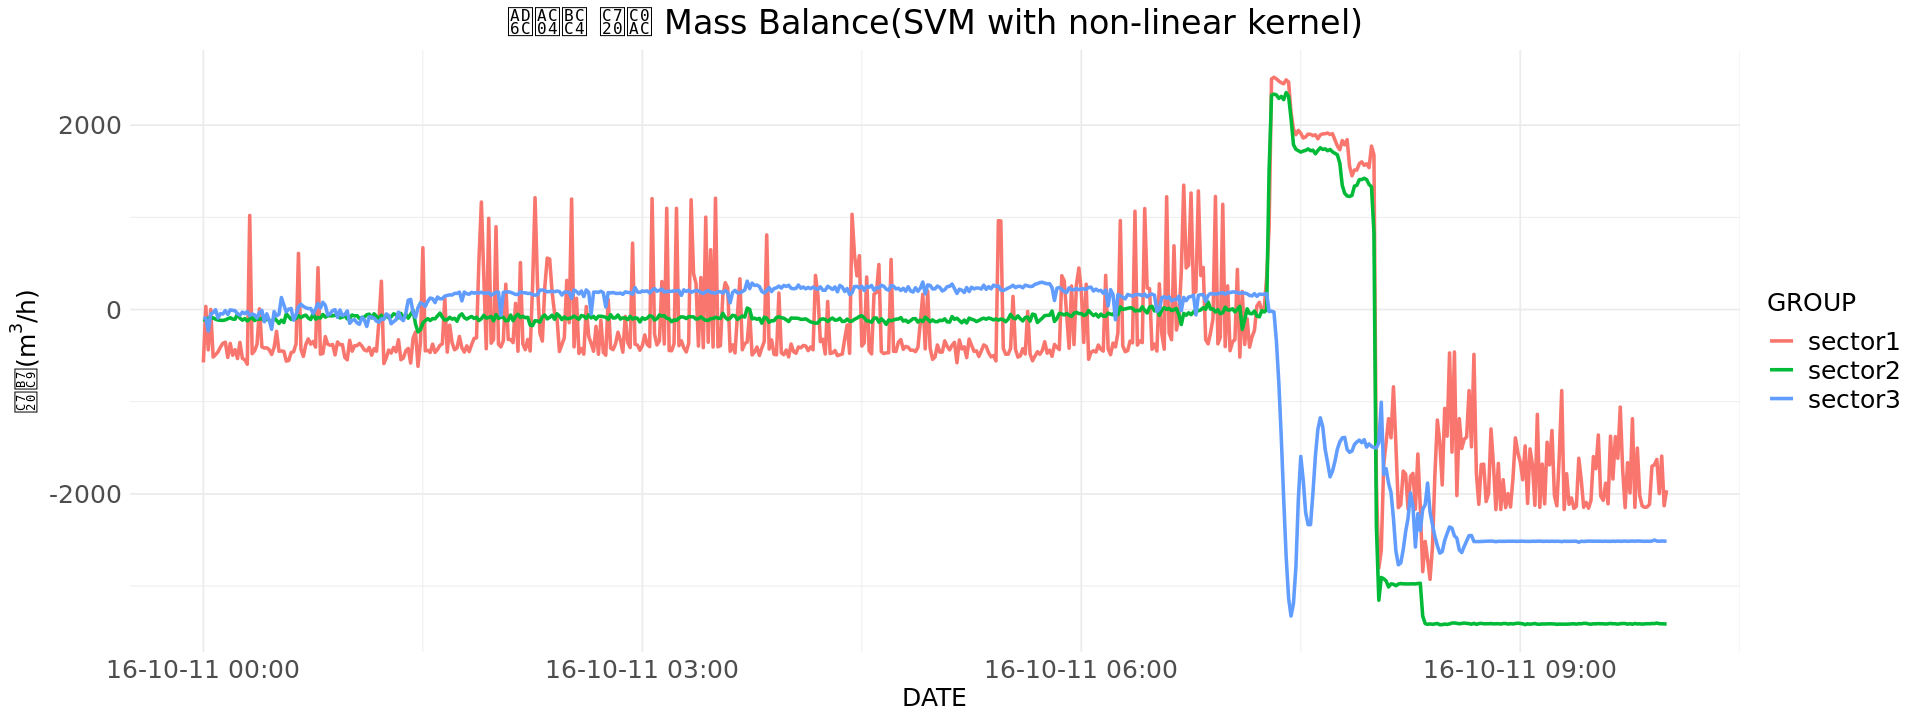

In [8]:
# Support Vector Machine(with non linear kernel)
ggplot(total_df, aes(x = DATE, y = (ACTUAL-SVM_RBF), group = GROUP)) + 
    geom_line(aes(color = GROUP), linewidth = 1) + ylab(expression(paste('유량(', m^{3}, '/h)'))) + 
    ggtitle('구간별 유사 Mass Balance(SVM with non-linear kernel)') +
    theme_minimal() + theme(plot.title = element_text(hjust = 0.5, size = 20), 
                            strip.text.x = element_text(size = 15), axis.title = element_text(size = 15), 
                            axis.text = element_text(size = 15), legend.text = element_text(size = 15), 
                            legend.title = element_text(size = 15)) + 
    scale_x_datetime(labels = date_format('%y-%m-%d %H:%M'))

비선형 서포트 벡터 머신을 활용한 구간별 유사 Mass Balance입니다.   
누수가 발생한 2구간에서 뿐만 아니라 1구간에서도 Mass Balance가 증가하는 모습을 확인할 수 있습니다. 따라서 비선형 서포트 벡터 머신을 통해 누수 구간을 식별할 수 없습니다.